In [87]:
import pandas as pd
import pydicom
from pathlib import Path
import SimpleITK as sitk
import glob
import csv
import os


In [93]:
# Function to convert a DICOM image to PNG
def dicom_to_png(dicom_path):
    dicom_path = Path(dicom_path)

    # Define the path for the PNG file by adding '_png.png' to the DICOM filename
    png_path = dicom_path.with_name(dicom_path.stem + "_png.png")

    # Loading the DICOM image
    dicom_image = sitk.ReadImage(str(dicom_path))

    # Converting the image to a numpy array
    img_array = sitk.GetArrayFromImage(dicom_image)

    # Normalize the values between 0 and 1
    img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())

    # Convert the image to 8-bit
    img_8bit = (img_normalized * 255).astype('uint8')

    # Create a new SimpleITK image from the normalized array
    img_sitk_8bit = sitk.GetImageFromArray(img_8bit)

    # Copy the data to the new image
    img_sitk_8bit.CopyInformation(dicom_image)

    # Save the new image as PNG in the same directory as the original DICOM
    sitk.WriteImage(img_sitk_8bit, str(png_path))
    
    #print(f"Image saved at: {png_path}")

    # Return the path of the PNG file
    return str(png_path)




In [ ]:
# Example usage
dicom_path = r"D:\TFG\Images\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-2017-DDSM-NA-96009\1.000000-full mammogram images-63992\1-1.dcm"
generated_png_path = dicom_to_png(dicom_path)
print(f"Generated PNG file at: {generated_png_path}")

In [159]:
# Function to find correspondence between a DICOM file and a row in the CSV
def find_correspondence(dicom_path, df, series_desc):
    dicom = pydicom.dcmread(dicom_path)
    
    study_id = str(dicom.StudyInstanceUID)
    series_id = str(dicom.SeriesInstanceUID)
    print("study_id", study_id, "series_id", series_id)

    # Ensure the relevant columns are strings
    df['ROI mask file path'] = df['ROI mask file path'].astype(str)
    df['image file path'] = df['image file path'].astype(str)
    df['cropped image file path'] = df['cropped image file path'].astype(str)

    # Apply the filtering based on SeriesDescription
    if "ROI" in series_desc:        
        row = df[
            (df['ROI mask file path'].str.contains(study_id)) &
            (df['ROI mask file path'].str.contains(series_id))
        ]
        
    elif "full" in series_desc:
        row = df[
            (df['image file path'].str.contains(study_id)) &
            (df['image file path'].str.contains(series_id))
        ]
    elif "cropped" in series_desc:
        row = df[
            (df['cropped image file path'].str.contains(study_id)) &
            (df['cropped image file path'].str.contains(series_id))
        ]
    if not row.empty:
        return row.iloc[0]  # Return the first matching row as a dictionary
    else:
        print("EMPTY", series_desc, dicom_path)
        return None

In [158]:
# Function to process DICOM files and update the CSV
def process_and_update(csv_path, dicom_directory, output_csv_path):

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path, sep=';')

    # Create a copy of the DataFrame to modify
    updated_df = df.copy()

    # Add new columns for the updated paths
    updated_df['updated png image file path'] = None
    updated_df['updated png cropped image file path'] = None
    updated_df['updated png ROI mask file path'] = None

    # Use glob to find all DICOM files in the specified directory
    dicom_files = glob.glob(f"{dicom_directory}/**/*.dcm", recursive=True)

    # Iterate through all DICOM files
    for dicom_path in dicom_files:
        # Read the DICOM file to extract SeriesDescription
        dicom_image = pydicom.dcmread(dicom_path)
        
        if hasattr(dicom_image, 'SeriesDescription'):
            series_description = dicom_image.SeriesDescription
            
        elif "full" in dicom_path.lower():
            series_description = "full mammogram images"

            
        elif "roi" in dicom_path.lower():
            # Remove the filename from the path

            parent_path = os.path.dirname(dicom_path.strip())  # Strip spaces and get parent directory

            # List all DICOM files in this folder
            dicom_files_in_folder = [
                f for f in os.listdir(parent_path) if os.path.isfile(os.path.join(parent_path, f)) and f.endswith(".dcm")
            ]

            # Assert that there are exactly two DICOM files in the folder
            assert len(dicom_files_in_folder) == 2, f"Expected 2 DICOM files in {parent_path}, found {len(dicom_files_in_folder)}"

            # Assign series_description based on file name
            if "1-1.dcm" in dicom_path:
                series_description = "cropped images"
            elif "1-2.dcm" in dicom_path:
                series_description = "ROI mask images"
        else:
            print("WARNING: Unexpected file naming convention for ROI folder:", dicom_path)
            continue

        # Find the corresponding row in the original DataFrame
        corresponding_row = find_correspondence(dicom_path, updated_df, series_description)

        # If a matching row is found, update the appropriate column
        if corresponding_row is not None:
            new_png_path = dicom_to_png(dicom_path)  # Convert the DICOM to PNG
            #print(series_description)
            if series_description == "full mammogram images":
                updated_df.loc[updated_df.index == corresponding_row.name, 'updated png image file path'] = new_png_path
            elif series_description == "cropped images":
                updated_df.loc[updated_df.index == corresponding_row.name, 'updated png cropped image file path'] = new_png_path
            elif series_description == "ROI mask images":
                updated_df.loc[updated_df.index == corresponding_row.name, 'updated png ROI mask file path'] = new_png_path

    # Remove rows with all NaN values (optional)
    updated_df = updated_df.dropna(how="all")

    # Save the updated DataFrame to a new CSV file
    updated_df.to_csv(output_csv_path, index=False)
    print(f"Updated CSV saved at: {output_csv_path}")
    
    png_files = glob.glob(f"{dicom_directory}/**/*.png", recursive=True)
    print("There were ", len(dicom_files), "DICOM FILES, ", len(png_files), "were converted to png.")
    print("There were ", len(dicom_files) - len(png_files), "dicoms which were not found. \n\n")
    
    
    missing_pngs = find_missing_pngs(dicom_directory)

    if missing_pngs:
        print(f"Found {len(missing_pngs)} DICOM files without corresponding PNG files:")
        for missing in missing_pngs:
            print(missing)
    else:
        print("All DICOM files have corresponding PNG files")


In [96]:
# Example usage
csv_path = r"D:\CBIS-DDSM\calc_case_description_test_set.csv"
output_csv_path = r"D:\Test Processing\updated_calc_case_description_test_set.csv"

csv_path_2 = r"D:\CBIS-DDSM\calc_case_description_train_set.csv"
output_csv_path_2 = r"D:\Test Processing\updated_calc_case_description_train_set.csv"

csv_path_3 = r"D:\CBIS-DDSM\mass_case_description_test_set.csv"
output_csv_path_3 = r"D:\Test Processing\updated_mass_case_description_test_set.csv"

csv_path_4 = r"D:\CBIS-DDSM\mass_case_description_train_set.csv"
output_csv_path_4 = r"D:\Test Processing\updated_mass_case_description_train_set.csv"

dicom_directory = r"D:\CBIS-DDSM"



####################################################################################################################

process_and_update(csv_path, dicom_directory, output_csv_path)

####################################################################################################################

process_and_update(csv_path_2, dicom_directory, output_csv_path_2)

####################################################################################################################

process_and_update(csv_path_3, dicom_directory, output_csv_path_3)

####################################################################################################################

process_and_update(csv_path_4, dicom_directory, output_csv_path_4)

####################################################################################################################

EMPTY ROI mask images D:\CBIS-DDSM\Train\Calc-Training_P_00005_RIGHT_CC_1\08-30-2017-DDSM-09081\1.000000-cropped images-94682\1-1.dcm
EMPTY cropped images D:\CBIS-DDSM\Train\Calc-Training_P_00005_RIGHT_CC_1\08-30-2017-DDSM-09081\1.000000-cropped images-94682\1-2.dcm
EMPTY cropped images D:\CBIS-DDSM\Train\Calc-Training_P_00005_RIGHT_MLO_1\09-06-2017-DDSM-81938\1.000000-ROI mask images-22894\1-1.dcm
EMPTY ROI mask images D:\CBIS-DDSM\Train\Calc-Training_P_00005_RIGHT_MLO_1\09-06-2017-DDSM-81938\1.000000-ROI mask images-22894\1-2.dcm
EMPTY cropped images D:\CBIS-DDSM\Train\Calc-Training_P_00008_LEFT_CC_3\09-06-2017-DDSM-57477\1.000000-ROI mask images-78483\1-1.dcm
EMPTY ROI mask images D:\CBIS-DDSM\Train\Calc-Training_P_00008_LEFT_CC_3\09-06-2017-DDSM-57477\1.000000-ROI mask images-78483\1-2.dcm
EMPTY cropped images D:\CBIS-DDSM\Train\Calc-Training_P_00008_RIGHT_CC_5\09-06-2017-DDSM-62037\1.000000-ROI mask images-82571\1-1.dcm
EMPTY ROI mask images D:\CBIS-DDSM\Train\Calc-Training_P_0000

In [149]:
####################################################################################################################

"""
PATIENT 00474 LEFT_MLO_1 (CALC TRAIN SET), MISSING PATIENT
"""

####################################################################################################################


#p_00474_csv = r"D:\Test Processing\patient_00474.csv"
#output_p_00474_csv = r"D:\Test Processing\updated_patient_00474.csv"
#p_00474_directory = r"D:\Test Processing\P_00474"

#process_and_update(p_00474_csv, p_00474_directory, output_p_00474_csv)





p_01152_csv = r"D:\Test Processing\patient_01152.csv"
output_p_01152_csv = r"D:\Test Processing\updated_patient_01152.csv"
p_01152_directory = r"D:\Test Processing\P_01152"

process_and_update(p_01152_csv, p_01152_directory, output_p_01152_csv)


0      False
1      False
2        NaN
3        NaN
4        NaN
       ...  
321      NaN
322      NaN
323      NaN
324      NaN
325      NaN
Name: cropped image file path, Length: 326, dtype: object
IT HAS 'full' IN ITS PATH:  full mammogram images
study_id 1.3.6.1.4.1.9590.100.1.2.204786255511122417607202046723320885062 series_id 1.3.6.1.4.1.9590.100.1.2.172930807011519106941584787631508021781
IT HAS SERIESDESCRIPTION:  cropped images
study_id 1.3.6.1.4.1.9590.100.1.2.405311769510813600210419150593225190253 series_id 1.3.6.1.4.1.9590.100.1.2.39736666212536574105910800691844259252
SERIESDESCRIPTION CONTAINS CROPPED
IT HAS SERIESDESCRIPTION:  ROI mask images
study_id 1.3.6.1.4.1.9590.100.1.2.405311769510813600210419150593225190253 series_id 1.3.6.1.4.1.9590.100.1.2.39736666212536574105910800691844259252
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_01152             2.0                RIGHT         CC             2.0   

  abnormality type  cal

Calc Type Counts and Percentages:
PLEOMORPHIC: 813 (43.99%)
AMORPHOUS: 181 (9.79%)
PUNCTATE: 132 (7.14%)
LUCENT_CENTER: 110 (5.95%)
FINE_LINEAR_BRANCHING: 102 (5.52%)
VASCULAR: 90 (4.87%)
COARSE: 39 (2.11%)
ROUND_AND_REGULAR-LUCENT_CENTER: 31 (1.68%)
PLEOMORPHIC-FINE_LINEAR_BRANCHING: 31 (1.68%)
PUNCTATE-PLEOMORPHIC: 30 (1.62%)
ROUND_AND_REGULAR: 27 (1.46%)
ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE: 24 (1.30%)
ROUND_AND_REGULAR-EGGSHELL: 23 (1.24%)
DYSTROPHIC: 20 (1.08%)
LUCENT_CENTERED: 18 (0.97%)
AMORPHOUS-PLEOMORPHIC: 16 (0.87%)
ROUND_AND_REGULAR-LUCENT_CENTERED: 14 (0.76%)
EGGSHELL: 13 (0.70%)
PUNCTATE-AMORPHOUS: 12 (0.65%)
LARGE_RODLIKE-ROUND_AND_REGULAR: 11 (0.60%)
COARSE-ROUND_AND_REGULAR-LUCENT_CENTER: 10 (0.54%)
ROUND_AND_REGULAR-PLEOMORPHIC: 8 (0.43%)
LUCENT_CENTER-PUNCTATE: 8 (0.43%)
VASCULAR-COARSE-LUCENT_CENTERED: 8 (0.43%)
VASCULAR-COARSE: 6 (0.32%)
PUNCTATE-FINE_LINEAR_BRANCHING: 6 (0.32%)
COARSE-LUCENT_CENTER: 6 (0.32%)
ROUND_AND_REGULAR-PUNCTATE: 5 (0.27%)
SKIN: 4 (0.22

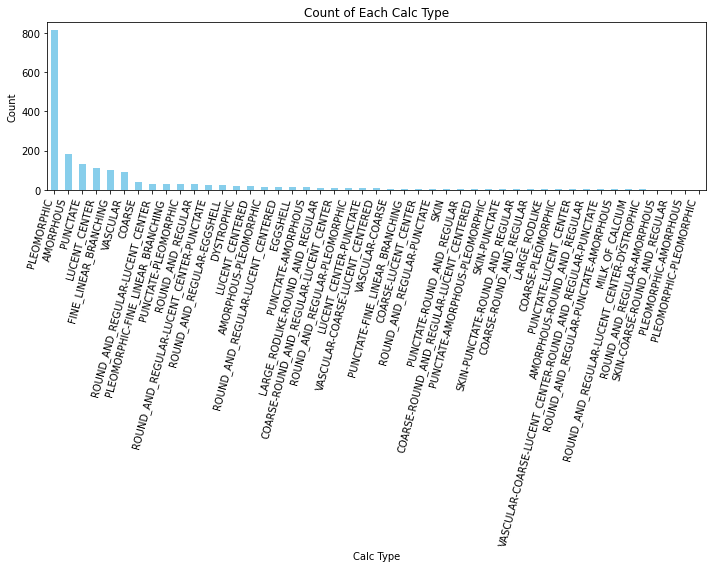

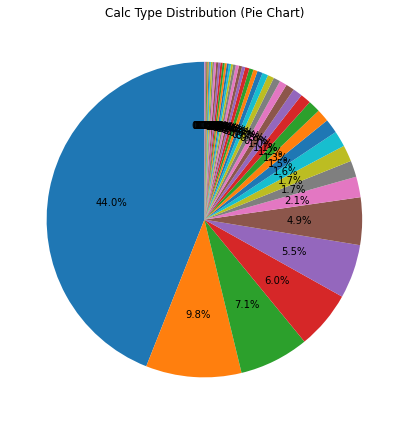


Calc Distribution Counts and Percentages:
CLUSTERED: 935 (65.25%)
SEGMENTAL: 202 (14.10%)
LINEAR: 112 (7.82%)
REGIONAL: 102 (7.12%)
DIFFUSELY_SCATTERED: 40 (2.79%)
CLUSTERED-LINEAR: 29 (2.02%)
LINEAR-SEGMENTAL: 7 (0.49%)
CLUSTERED-SEGMENTAL: 5 (0.35%)
REGIONAL-REGIONAL: 1 (0.07%)


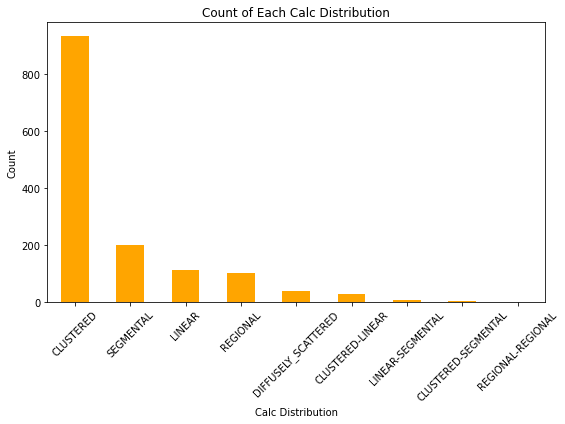

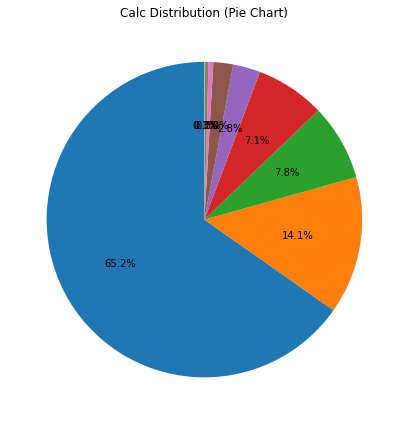


Pathology Counts and Percentages:
MALIGNANT: 673 (35.95%)
BENIGN: 658 (35.15%)
BENIGN_WITHOUT_CALLBACK: 541 (28.90%)

MALIGNANT vs BENIGN:
MALIGNANT: 673 (35.95%)
BENIGN: 1199 (64.05%)


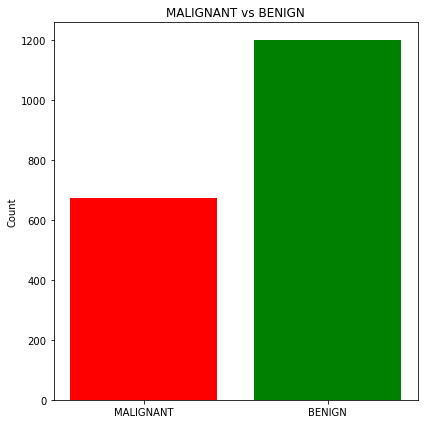

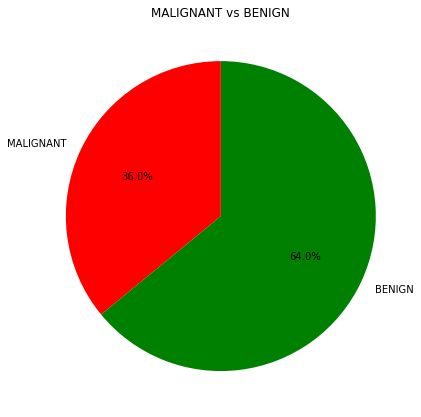


BENIGN vs BENIGN_WITHOUT_CALLBACK:
BENIGN: 658 (54.88%)
BENIGN_WITHOUT_CALLBACK: 541 (45.12%)


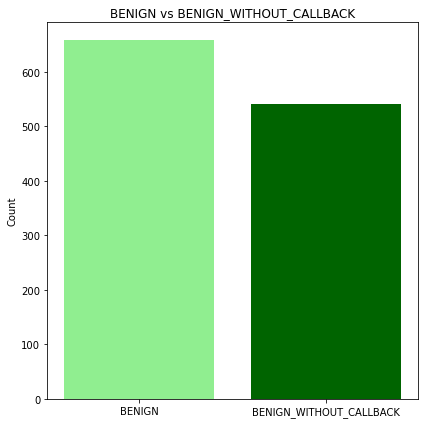

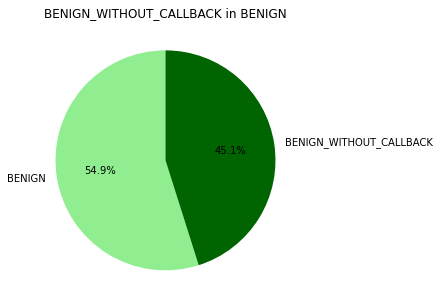


Breast Density Counts and Percentages:
Density 0: 2 (0.11%)
Density 1: 199 (10.63%)
Density 2: 616 (32.91%)
Density 3: 654 (34.94%)
Density 4: 401 (21.42%)


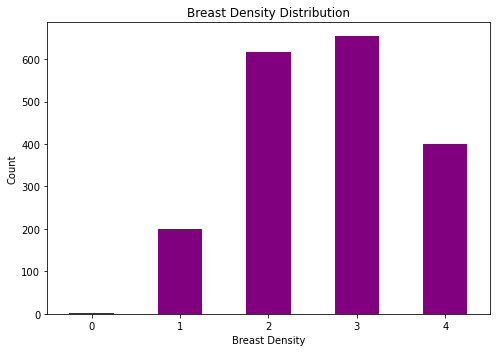

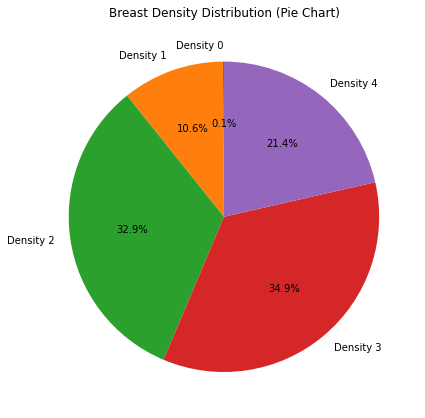

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
csv_path = r'D:\CBIS-DDSM\full_calc_dataset.csv'
df = pd.read_csv(csv_path, sep=';', engine='python', on_bad_lines='skip')

# Remove rows with N/A in specific columns
df_calc_type = df.dropna(subset=["calc type"])
df_calc_distribution = df.dropna(subset=["calc distribution"])
df_pathology = df.dropna(subset=["pathology"])
df_density = df.dropna(subset=["breast density"])

# ----------- Analysis 1: Calc Type -----------
calc_type_counts = df_calc_type["calc type"].value_counts()
print("Calc Type Counts and Percentages:")
for label, count in calc_type_counts.items():
    pct = count / len(df_calc_type) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

# Bar chart
plt.figure(figsize=(10, 8))
calc_type_counts.plot(kind="bar", color="skyblue")
plt.title("Count of Each Calc Type")
plt.xlabel("Calc Type")
plt.ylabel("Count")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(calc_type_counts.values, autopct='%1.1f%%', startangle=90)
plt.title("Calc Type Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# ----------- Analysis 2: Calc Distribution -----------
calc_distribution_counts = df_calc_distribution["calc distribution"].value_counts()
print("\nCalc Distribution Counts and Percentages:")
for label, count in calc_distribution_counts.items():
    pct = count / len(df_calc_distribution) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

# Bar and pie charts
plt.figure(figsize=(8, 6))
calc_distribution_counts.plot(kind="bar", color="orange")
plt.title("Count of Each Calc Distribution")
plt.xlabel("Calc Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(calc_distribution_counts.values, autopct='%1.1f%%', startangle=90)
plt.title("Calc Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# ----------- Analysis 3: Pathology -----------
pathology_counts = df_pathology["pathology"].value_counts()
print("\nPathology Counts and Percentages:")
for label, count in pathology_counts.items():
    pct = count / len(df_pathology) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

benign_malignant_counts = {
    "MALIGNANT": pathology_counts.get("MALIGNANT", 0),
    "BENIGN": pathology_counts.get("BENIGN", 0) + pathology_counts.get("BENIGN_WITHOUT_CALLBACK", 0),
}
total = sum(benign_malignant_counts.values())
print("\nMALIGNANT vs BENIGN:")
for label, count in benign_malignant_counts.items():
    pct = count / total * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(6, 6))
plt.bar(benign_malignant_counts.keys(), benign_malignant_counts.values(), color=["red", "green"])
plt.title("MALIGNANT vs BENIGN")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(benign_malignant_counts.values(), labels=benign_malignant_counts.keys(), autopct='%1.1f%%', startangle=90, colors=["red", "green"])
plt.title("MALIGNANT vs BENIGN")
plt.tight_layout()
plt.show()

benign_counts = {
    "BENIGN": pathology_counts.get("BENIGN", 0),
    "BENIGN_WITHOUT_CALLBACK": pathology_counts.get("BENIGN_WITHOUT_CALLBACK", 0),
}
total_benign = sum(benign_counts.values())
print("\nBENIGN vs BENIGN_WITHOUT_CALLBACK:")
for label, count in benign_counts.items():
    pct = count / total_benign * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(6, 6))
plt.bar(benign_counts.keys(), benign_counts.values(), color=["lightgreen", "darkgreen"])
plt.title("BENIGN vs BENIGN_WITHOUT_CALLBACK")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(benign_counts.values(), labels=benign_counts.keys(), autopct='%1.1f%%', startangle=90, colors=["lightgreen", "darkgreen"])
plt.title("BENIGN_WITHOUT_CALLBACK in BENIGN")
plt.tight_layout()
plt.show()

# ----------- Analysis 4: Breast Density -----------
density_counts = df_density["breast density"].value_counts().sort_index()
print("\nBreast Density Counts and Percentages:")
for label, count in density_counts.items():
    pct = count / len(df_density) * 100
    print(f"Density {label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(7, 5))
density_counts.plot(kind="bar", color="purple")
plt.title("Breast Density Distribution")
plt.xlabel("Breast Density")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(density_counts.values, labels=[f'Density {d}' for d in density_counts.index], autopct='%1.1f%%', startangle=90)
plt.title("Breast Density Distribution (Pie Chart)")
plt.tight_layout()
plt.show()


Mass Shape Counts and Percentages:
IRREGULAR: 464 (27.42%)
OVAL: 412 (24.35%)
LOBULATED: 384 (22.70%)
ROUND: 164 (9.69%)
ARCHITECTURAL_DISTORTION: 103 (6.09%)
IRREGULAR-ARCHITECTURAL_DISTORTION: 52 (3.07%)
LYMPH_NODE: 35 (2.07%)
FOCAL_ASYMMETRIC_DENSITY: 25 (1.48%)
ASYMMETRIC_BREAST_TISSUE: 25 (1.48%)
OVAL-LYMPH_NODE: 6 (0.35%)
LOBULATED-IRREGULAR: 6 (0.35%)
LOBULATED-LYMPH_NODE: 4 (0.24%)
ROUND-OVAL: 3 (0.18%)
LOBULATED-ARCHITECTURAL_DISTORTION: 2 (0.12%)
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY: 2 (0.12%)
IRREGULAR-ASYMMETRIC_BREAST_TISSUE: 1 (0.06%)
OVAL-LOBULATED: 1 (0.06%)
LOBULATED-OVAL: 1 (0.06%)
ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION: 1 (0.06%)
ROUND-LOBULATED: 1 (0.06%)


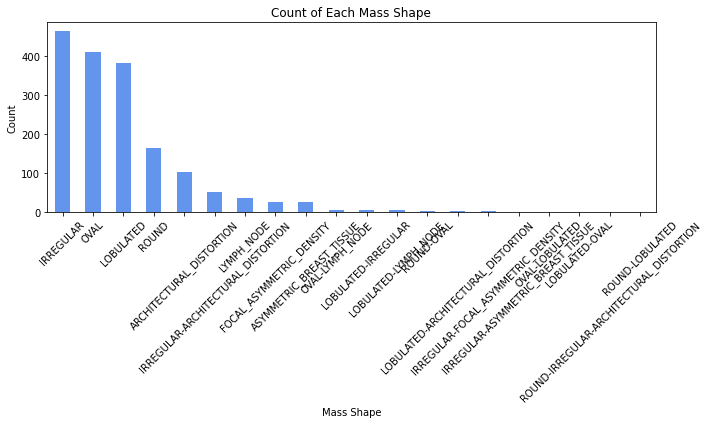

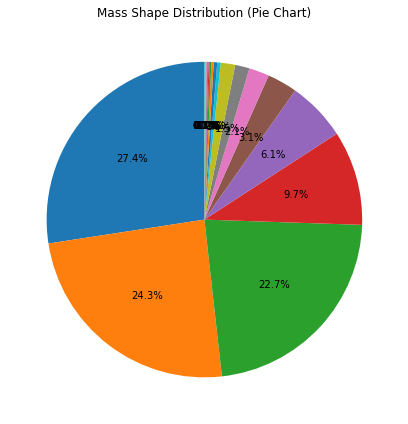


Mass Margins Counts and Percentages:
CIRCUMSCRIBED: 392 (23.96%)
ILL_DEFINED: 370 (22.62%)
SPICULATED: 363 (22.19%)
OBSCURED: 247 (15.10%)
MICROLOBULATED: 129 (7.89%)
ILL_DEFINED-SPICULATED: 30 (1.83%)
CIRCUMSCRIBED-ILL_DEFINED: 29 (1.77%)
OBSCURED-ILL_DEFINED: 24 (1.47%)
CIRCUMSCRIBED-OBSCURED: 22 (1.34%)
MICROLOBULATED-ILL_DEFINED: 5 (0.31%)
OBSCURED-ILL_DEFINED-SPICULATED: 5 (0.31%)
CIRCUMSCRIBED-OBSCURED-ILL_DEFINED: 4 (0.24%)
OBSCURED-SPICULATED: 4 (0.24%)
CIRCUMSCRIBED-MICROLOBULATED-ILL_DEFINED: 3 (0.18%)
CIRCUMSCRIBED-MICROLOBULATED: 2 (0.12%)
OBSCURED-CIRCUMSCRIBED: 2 (0.12%)
MICROLOBULATED-ILL_DEFINED-SPICULATED: 2 (0.12%)
MICROLOBULATED-SPICULATED: 2 (0.12%)
CIRCUMSCRIBED-SPICULATED: 1 (0.06%)


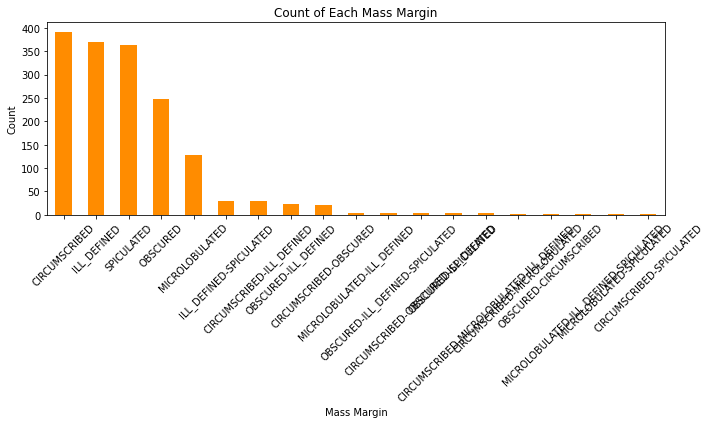

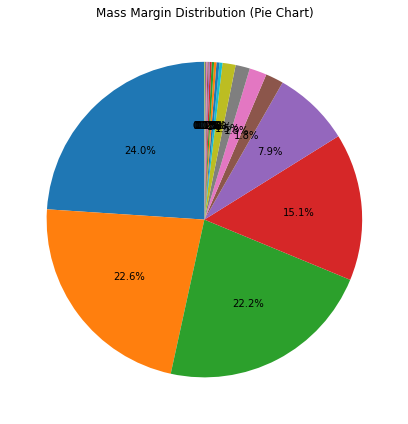


Pathology Counts and Percentages:
MALIGNANT: 784 (46.23%)
BENIGN: 771 (45.46%)
BENIGN_WITHOUT_CALLBACK: 141 (8.31%)

MALIGNANT vs BENIGN:
MALIGNANT: 784 (46.23%)
BENIGN: 912 (53.77%)


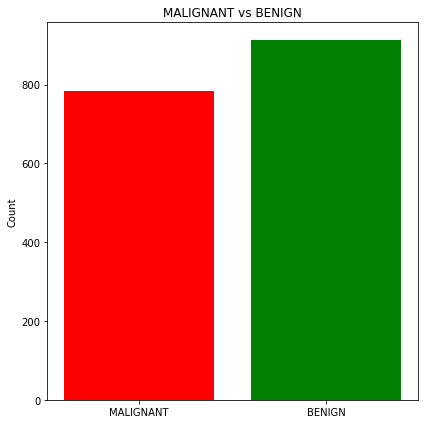

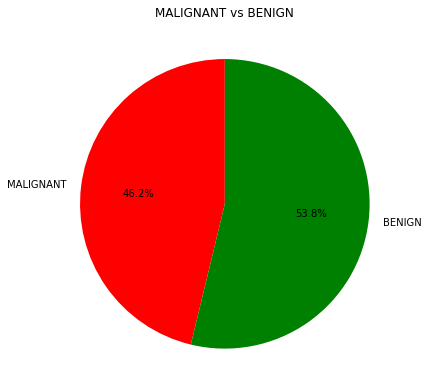


BENIGN vs BENIGN_WITHOUT_CALLBACK:
BENIGN: 771 (84.54%)
BENIGN_WITHOUT_CALLBACK: 141 (15.46%)


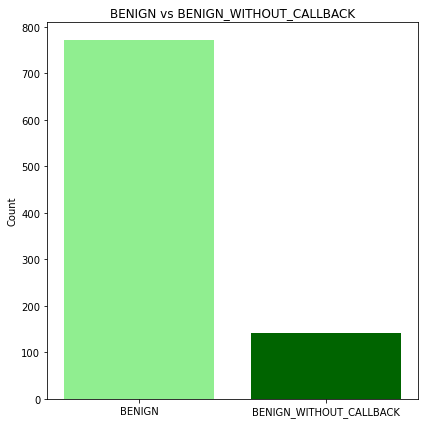

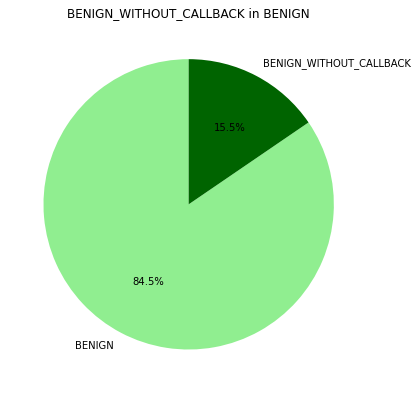


Breast Density Counts and Percentages:
Density 1: 337 (19.87%)
Density 2: 757 (44.63%)
Density 3: 449 (26.47%)
Density 4: 153 (9.02%)


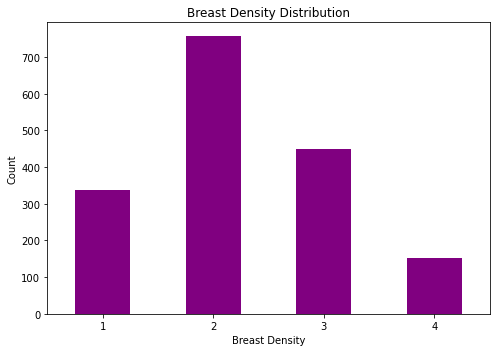

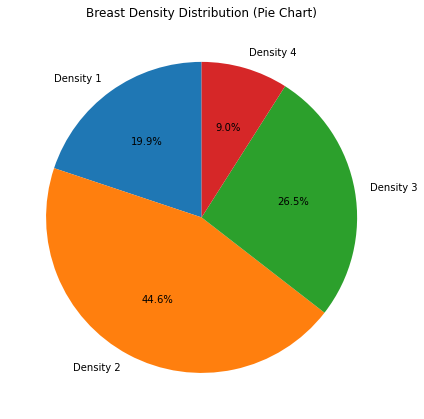

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
csv_path = r'D:\CBIS-DDSM\full_mass_dataset.csv'
df = pd.read_csv(csv_path, sep=';', engine='python', on_bad_lines='skip')

# Clean subsets
df_shape = df.dropna(subset=["mass shape"])
df_margins = df.dropna(subset=["mass margins"])
df_pathology = df.dropna(subset=["pathology"])
df_density = df.dropna(subset=["breast_density"])

# ----------- Analysis 1: Mass Shape -----------
shape_counts = df_shape["mass shape"].value_counts()
print("Mass Shape Counts and Percentages:")
for label, count in shape_counts.items():
    pct = count / len(df_shape) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(10, 6))
shape_counts.plot(kind="bar", color="cornflowerblue")
plt.title("Count of Each Mass Shape")
plt.xlabel("Mass Shape")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(shape_counts.values, autopct='%1.1f%%', startangle=90)
plt.title("Mass Shape Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# ----------- Analysis 2: Mass Margins -----------
margins_counts = df_margins["mass margins"].value_counts()
print("\nMass Margins Counts and Percentages:")
for label, count in margins_counts.items():
    pct = count / len(df_margins) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(10, 6))
margins_counts.plot(kind="bar", color="darkorange")
plt.title("Count of Each Mass Margin")
plt.xlabel("Mass Margin")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(margins_counts.values, autopct='%1.1f%%', startangle=90)
plt.title("Mass Margin Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# ----------- Analysis 3: Pathology -----------
pathology_counts = df_pathology["pathology"].value_counts()
print("\nPathology Counts and Percentages:")
for label, count in pathology_counts.items():
    pct = count / len(df_pathology) * 100
    print(f"{label}: {count} ({pct:.2f}%)")

benign_malignant_counts = {
    "MALIGNANT": pathology_counts.get("MALIGNANT", 0),
    "BENIGN": pathology_counts.get("BENIGN", 0) + pathology_counts.get("BENIGN_WITHOUT_CALLBACK", 0),
}
total = sum(benign_malignant_counts.values())
print("\nMALIGNANT vs BENIGN:")
for label, count in benign_malignant_counts.items():
    pct = count / total * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(6, 6))
plt.bar(benign_malignant_counts.keys(), benign_malignant_counts.values(), color=["red", "green"])
plt.title("MALIGNANT vs BENIGN")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(benign_malignant_counts.values(), labels=benign_malignant_counts.keys(), autopct='%1.1f%%', startangle=90, colors=["red", "green"])
plt.title("MALIGNANT vs BENIGN")
plt.tight_layout()
plt.show()

benign_counts = {
    "BENIGN": pathology_counts.get("BENIGN", 0),
    "BENIGN_WITHOUT_CALLBACK": pathology_counts.get("BENIGN_WITHOUT_CALLBACK", 0),
}
total_benign = sum(benign_counts.values())
print("\nBENIGN vs BENIGN_WITHOUT_CALLBACK:")
for label, count in benign_counts.items():
    pct = count / total_benign * 100
    print(f"{label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(6, 6))
plt.bar(benign_counts.keys(), benign_counts.values(), color=["lightgreen", "darkgreen"])
plt.title("BENIGN vs BENIGN_WITHOUT_CALLBACK")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(benign_counts.values(), labels=benign_counts.keys(), autopct='%1.1f%%', startangle=90, colors=["lightgreen", "darkgreen"])
plt.title("BENIGN_WITHOUT_CALLBACK in BENIGN")
plt.tight_layout()
plt.show()

# ----------- Analysis 4: Breast Density -----------
density_counts = df_density["breast_density"].value_counts().sort_index()
print("\nBreast Density Counts and Percentages:")
for label, count in density_counts.items():
    pct = count / len(df_density) * 100
    print(f"Density {label}: {count} ({pct:.2f}%)")

plt.figure(figsize=(7, 5))
density_counts.plot(kind="bar", color="purple")
plt.title("Breast Density Distribution")
plt.xlabel("Breast Density")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(density_counts.values, labels=[f'Density {d}' for d in density_counts.index], autopct='%1.1f%%', startangle=90)
plt.title("Breast Density Distribution (Pie Chart)")
plt.tight_layout()
plt.show()


In [ ]:
#Estudiar Breast Density

In [98]:
from pathlib import Path

# Original path
path = Path(r"D:\Test Processing\P_01152\Calc-Test_P_01152_RIGHT_CC\08-29-2017-DDSM-85062\1.000000-full mammogram images-21781\1-1.dcm")

# Remove the last part (file or folder name)
parent_path = path.parent

print(parent_path)


D:\Test Processing\P_01152\Calc-Test_P_01152_RIGHT_CC\08-29-2017-DDSM-85062\1.000000-full mammogram images-21781


In [90]:
def delete_png_files(directory):
    # Use glob to find all .png files in the directory and its subdirectories
    png_files = glob.glob(f"{directory}/**/*.png", recursive=True)
    print("There are", len(png_files), ".png")
    
    # Loop through each file and remove it
    for png_file in png_files:
        try:
            os.remove(png_file)
        except Exception as e:
            print(f"Error deleting {png_file}: {e}")
    
    png_files = glob.glob(f"{directory}/**/*.png", recursive=True)
    print("At the end, there are", len(png_files), ".png")



In [94]:
directory_png_remove = r"D:\CBIS-DDSM"  
delete_png_files(directory_png_remove)

There are 2116 .png
At the end, there are 0 .png


In [111]:
def find_missing_pngs(dicom_directory):
    # Get all .dcm and .png files in the directory and subdirectories
    dicom_files = glob.glob(f"{dicom_directory}/**/*.dcm", recursive=True)
    png_files = glob.glob(f"{dicom_directory}/**/*.png", recursive=True)

    # Create a set of parent directories for .png files
    png_dirs = {os.path.dirname(png) for png in png_files}

    # Find .dcm files without corresponding .png files in the same directory
    missing_pngs = [dcm for dcm in dicom_files if os.path.dirname(dcm) not in png_dirs]

    return missing_pngs

In [113]:
dicom_directory = r"D:\CBIS-DDSM"
missing_pngs = find_missing_pngs(dicom_directory)

if missing_pngs:
    print(f"Found {len(missing_pngs)} DICOM files without corresponding PNG files:")
    for missing in missing_pngs:
        print(missing)
else:
    print("All DICOM files have corresponding PNG files")

Found 2 DICOM files without corresponding PNG files:
D:\CBIS-DDSM\Train\Calc-Training_P_00474_LEFT_MLO_1\09-21-2017-DDSM-11708\1.000000-cropped images-23803\1-1.dcm
D:\CBIS-DDSM\Train\Calc-Training_P_00474_LEFT_MLO_1\09-06-2017-DDSM-12715\1.000000-ROI mask images-91565\1-1.dcm


In [5]:
def split_train_set(csv_path, train_path, validation_path, validation_percentage):
    """
    Splits a dataset into training and validation sets, ensuring no patient data is split between sets.

    Args:
        csv_path (str): Path to the input CSV file.
        train_path (str): Path to save the training set CSV.
        validation_path (str): Path to save the validation set CSV.
        validation_percentage (float): Percentage of data to allocate to the validation set (0-100).

    Returns:
        None
    """
    # Normalize the percentage to a fraction
    validation_fraction = validation_percentage / 100.0

    # Load the CSV into a DataFrame
    df = pd.read_csv(csv_path, sep=';')

    # Group the data by patient_id
    grouped = df.groupby('patient_id')

    # Shuffle patient IDs
    patient_ids = list(grouped.groups.keys())
    random.shuffle(patient_ids)

    # Initialize lists for validation and training sets
    validation_ids = []
    train_ids = []

    # Counter for rows added to the validation set
    validation_row_count = 0
    target_validation_rows = int(len(df) * validation_fraction)

    # Allocate patients to validation set until the target is met or exceeded
    for patient_id in patient_ids:
        patient_rows = len(grouped.get_group(patient_id))
        if validation_row_count < target_validation_rows:
            validation_ids.append(patient_id)
            validation_row_count += patient_rows
        else:
            train_ids.append(patient_id)

    # Create DataFrames for the validation and training sets
    validation_set = df[df['patient_id'].isin(validation_ids)]
    train_set = df[df['patient_id'].isin(train_ids)]

    # Save the new datasets to CSV
    validation_set.to_csv(validation_path, index=False)
    train_set.to_csv(train_path, index=False)

    print(f"Validation set saved to: {validation_path}")
    print(f"Training set saved to: {train_path}")


In [13]:

train_csv_path_calc = r"D:\Test Processing\UPDATED_CSVs\updated_calc_case_description_train_set.csv"
train_split_path_calc = r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\CALC\updated_train_split_calc_case_description_train_set_train_split.csv"
validation_split_path_calc = r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\CALC\updated_validation_split_calc_case_description_train_set_train_split.csv"
validation_percentage_calc = 25

#split_train_set(train_csv_path_calc, train_split_path_calc, validation_split_path_calc, validation_percentage_calc)



train_csv_path_mass = r"D:\Test Processing\UPDATED_CSVs\updated_mass_case_description_train_set.csv"
train_split_path_mass = r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv"
validation_split_path_mass = r"D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_validation_split_mass_case_description_train_set.csv"
validation_percentage_mass = 25

#split_train_set(train_csv_path_mass, train_split_path_mass, validation_split_path_mass, validation_percentage_mass)


Validation set saved to: D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\CALC\updated_validation_split_calc_case_description_train_set_train_split.csv
Training set saved to: D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\CALC\updated_train_split_calc_case_description_train_set_train_split.csv
Validation set saved to: D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_validation_split_mass_case_description_train_set.csv
Training set saved to: D:\Test Processing\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv


In [5]:
import pandas as pd
import sys
import os

def update_paths(csv_path):
    # Cargar el CSV en un DataFrame
    df = pd.read_csv(csv_path, sep=';')

    # Columnas a modificar
    columns_to_update = [
        "updated png image file path",
        "updated png cropped image file path",
        "updated png ROI mask file path"
    ]

    # Función para convertir el path de Windows a Linux
    def convert_path(win_path):
        if pd.isna(win_path) or not isinstance(win_path, str):
            return win_path  # Devolver el valor original si es NaN o no es string
        
        # Reemplazar la parte inicial del path de Windows por la nueva en Linux
        new_path = win_path.replace("D:\\CBIS-DDSM", "/home/christian/CBIS-DDSM/Dataset/CBIS-DDSM")
        
        # Reemplazar las barras invertidas por barras normales
        new_path = new_path.replace("\\", "/")
        
        return new_path

    # Aplicar la conversión a cada columna especificada
    for col in columns_to_update:
        if col in df.columns:
            df[col] = df[col].apply(convert_path)
        else:
            print(f"Warning: Column '{col}' not found in CSV.")

    # Sobrescribir el CSV con los nuevos paths
    df.to_csv(csv_path, index=False)
    print(f"Updated paths in: {csv_path}")



In [14]:
update_paths(r"C:\Users\Christian\Downloads\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv")

Updated paths in: C:\Users\Christian\Downloads\UPDATED_CSVs\SPLITTED_TRAIN_SETS\MASS\updated_train_split_mass_case_description_train_set.csv


In [1]:
import pandas as pd
import os
import sys

def merge_csv(file1, file2):
    """
    Merge two CSV files and save the merged file in the same directory.

    Args:
        file1 (str): Path to the first CSV file.
        file2 (str): Path to the second CSV file.
    """
    # Verify that both files exist
    if not os.path.exists(file1) or not os.path.exists(file2):
        print("Error: One or both CSV files do not exist.")
        return
    
    # Read CSV files
    df1 = pd.read_csv(file1, sep=';')
    df2 = pd.read_csv(file2, sep=';')
    
    # Merge the two DataFrames
    merged_df = pd.concat([df1, df2], ignore_index=True)
    
    # Get the directory of the input files
    output_dir = os.path.dirname(file1)
    
    # Define output file name
    output_file = os.path.join(output_dir, "merged_output.csv")
    
    # Save merged CSV
    merged_df.to_csv(output_file, index=False)
    
    print(f"Merged CSV saved as: {output_file}")

In [4]:
merge_csv(r"C:\Users\Christian\Downloads\UPDATED_VM_CSVs\SPLITTED_TRAIN_SETS\updated_mass_case_description_test_set.csv", r"C:\Users\Christian\Downloads\UPDATED_VM_CSVs\SPLITTED_TRAIN_SETS\updated_calc_case_description_test_set.csv")

✅ Merged CSV saved as: C:\Users\Christian\Downloads\UPDATED_VM_CSVs\SPLITTED_TRAIN_SETS\merged_output.csv
